## Reward-effort task simulations

In [571]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Simulate participants

In [591]:
# Trial numbers (40 mins, 6s per trial, 400 total trials)
num_trials = 400
num_blocks = 8 # 2 action type x 2 global effort state x 2 attentional focus
num_trials_per_block = num_blocks / num_blocks

# Reward and effort levels
outcome_levels_n = np.linspace(-10, 10, 11) 
outcome_levels = outcome_levels_n[outcome_levels_n != 0] # remove 0
effort_levels = np.linspace(5, 10, 11) 


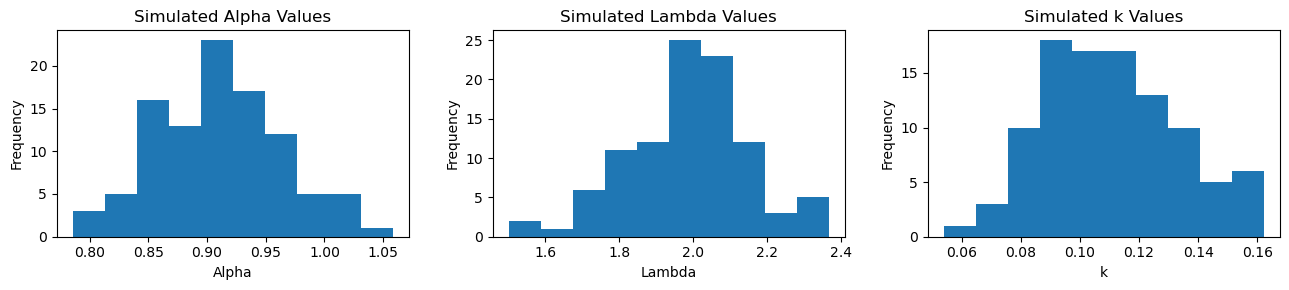

In [592]:
# Simulate participants with different sensitivities - get realistic values from the literature
num_participants = 100

# Specify mean and sd of parameters
alpha_mean, alpha_std = 0.9, 0.05
lambda_mean, lambda_std = 2.0, 0.2
k_mean, k_std = 0.11, 0.02

# Generate parameters from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)

# Ensure parameters are within a reasonable range
alpha_values = np.clip(alpha_values, 0.7, 1.2)
lambda_values = np.clip(lambda_values, 1.5, 2.5)
k_values = np.clip(k_values, 0, 1)


# Plot histograms of the parameters
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 3))

axes[0].hist(alpha_values)
axes[0].set_title('Simulated Alpha Values')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Frequency')

axes[1].hist(lambda_values)
axes[1].set_title('Simulated Lambda Values')
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('Frequency')

axes[2].hist(k_values)
axes[2].set_title('Simulated k Values')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

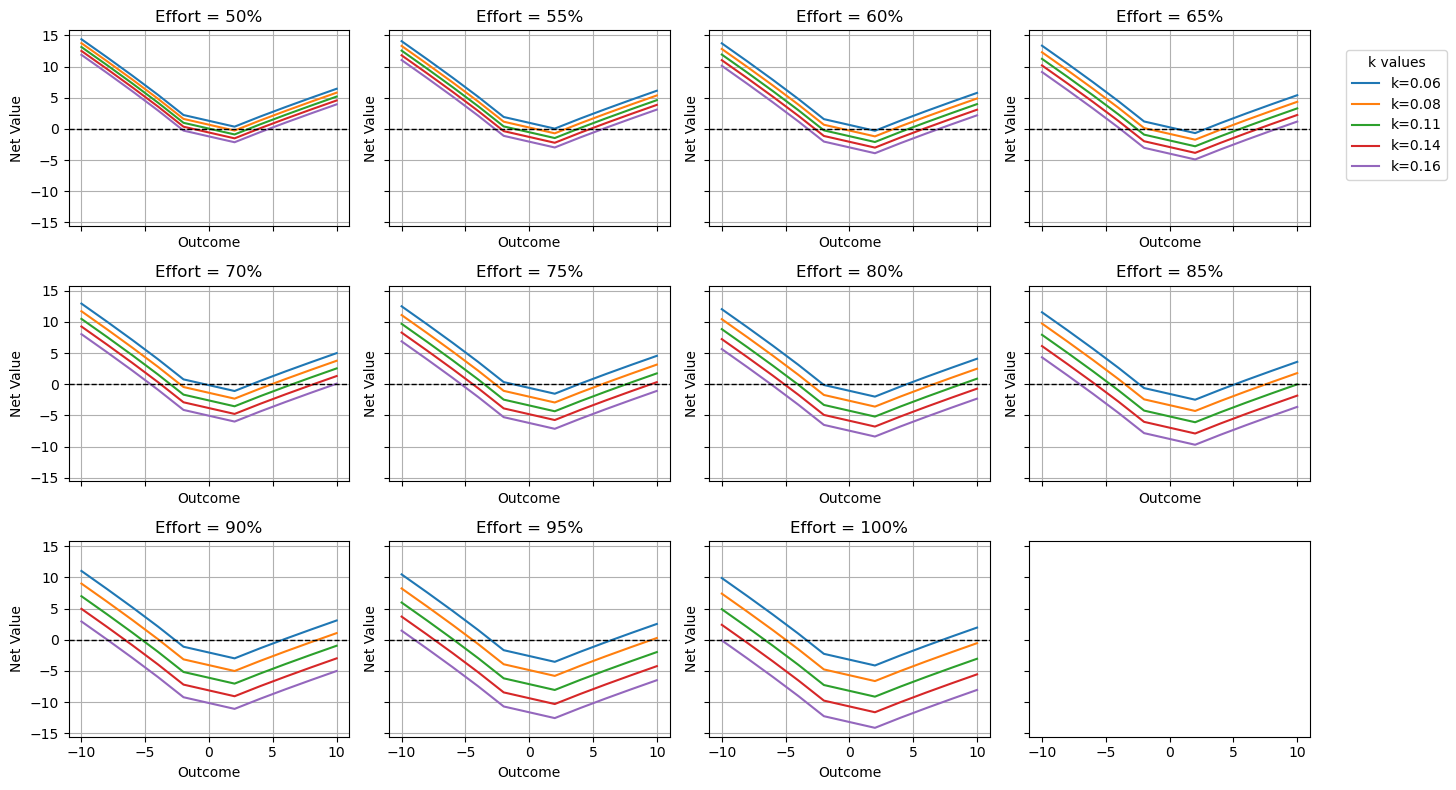

In [593]:
# Function to calculate net value based on outcome, effort, reward sensitivity alpha, loss sensitivty beta, effort sensitivity k, and loss aversion lambda
def calculate_net_value(outcome, effort, alpha, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # positive outcome - effort --> the higher the better
    else:
        return abs(-lambda_ * ((-outcome) ** alpha)) - k * (effort ** 2)  # removing the negative sign from the outcome to get magnitude of (negative) outcome - magnitude of effort --> the higher the less bad (ie better)



# Plot the net value function for different ks at different effort levels, fixing alpha and lambda at their mean values
plot_ks = np.linspace(0.06, 0.16, 5)  # different values for k
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()
for i, plot_effort in enumerate(effort_levels):
    ax = axes[i]
    for plot_k in plot_ks:
        net_values = [calculate_net_value(outcome, plot_effort, alpha_mean, plot_k, lambda_mean) for outcome in outcome_levels]
        ax.plot(outcome_levels, net_values, label=f'k={plot_k:.2f}')
    ax.set_title(f'Effort = {(plot_effort*10).astype(int)}%')
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Net Value')
    ax.axhline(0, color='black', lw=1, linestyle='--')
    ax.grid(True)
    if i == 0: 
        fig.legend(loc='center left', bbox_to_anchor=(0.96, 0.85), title="k values")
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

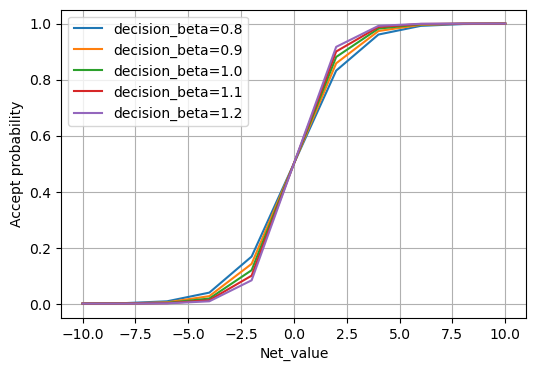

In [594]:
# Logistic function to get choice probabilities
decision_beta = 1  
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))


# Plot the Logistic function for different betas
plot_betas = np.linspace(0.8, 1.2, 5)
plt.figure(figsize=(6, 4))
for b in plot_betas:
    plt.plot(outcome_levels_n, logistic_choice_prob(outcome_levels_n, b), label=f'decision_beta={b:.1f}')
plt.xlabel('Net_value')
plt.ylabel('Accept probability')
plt.legend()
plt.grid(True)
plt.show()

In [595]:
# Generate stimuli and responses
stimuli = []
responses = []

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                               for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
        
        # Apply logistic function to calculate acceptance probabilities
        probabilities = logistic_choice_prob(net_values, decision_beta)
        
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array
responses = np.array(responses)



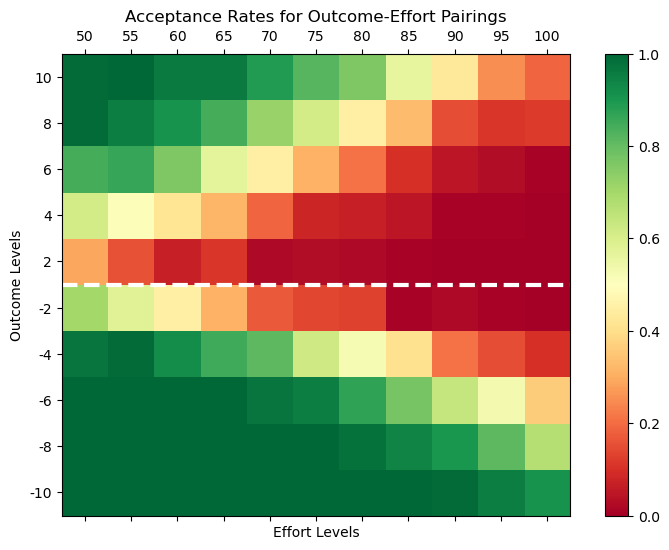

In [596]:
# Visualizing the acceptance rates for each reward-effort pairing across all participants
# Matrix looks asymmetric because of loss aversion
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates for plotting 
# acceptance_rates is a 1D array representing the mean acceptance rates across all participants for each reward-effort pairing
# reshaped acceptance_matrix is a 2D array where rows represent different outcome levels and columns represent different effort levels
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

fig, ax = plt.subplots(figsize=(9, 6))
cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(effort_levels)))
ax.set_yticks(np.arange(len(outcome_levels)))
ax.set_xticklabels((effort_levels*10).astype(int))
ax.set_yticklabels(outcome_levels.astype(int))
ax.invert_yaxis()
lowest_reward_index = np.where(outcome_levels == 2)[0][0]
ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)

plt.xlabel('Effort Levels')
plt.ylabel('Outcome Levels')
plt.title('Acceptance Rates for Outcome-Effort Pairings')
plt.show()


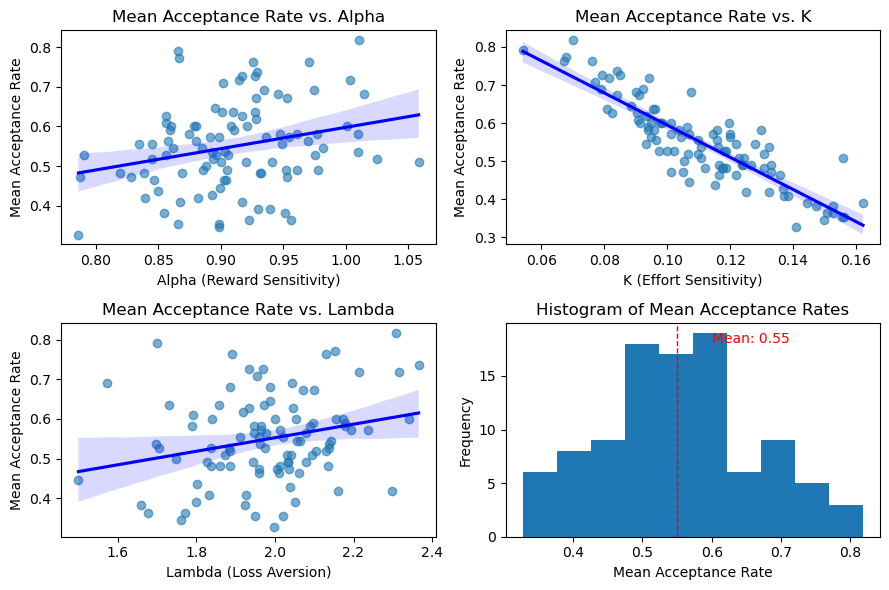

In [597]:
# Calculate mean acceptance rates
mean_acceptance_rates = responses.mean(axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot for Alpha vs. Mean Acceptance Rate
sns.regplot(x=alpha_values, y=mean_acceptance_rates, ax=axs[0, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 0].set_xlabel('Alpha (Reward Sensitivity)')
axs[0, 0].set_ylabel('Mean Acceptance Rate')
axs[0, 0].set_title('Mean Acceptance Rate vs. Alpha')

# Plot for K vs. Mean Acceptance Rate
sns.regplot(x=k_values, y=mean_acceptance_rates, ax=axs[0, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 1].set_xlabel('K (Effort Sensitivity)')
axs[0, 1].set_ylabel('Mean Acceptance Rate')
axs[0, 1].set_title('Mean Acceptance Rate vs. K')

# Plot for Lambda vs. Mean Acceptance Rate
sns.regplot(x=lambda_values, y=mean_acceptance_rates, ax=axs[1, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[1, 0].set_xlabel('Lambda (Loss Aversion)')
axs[1, 0].set_ylabel('Mean Acceptance Rate')
axs[1, 0].set_title('Mean Acceptance Rate vs. Lambda')

# Plot histogram of mean acceptance rates
axs[1, 1].hist(mean_acceptance_rates)
axs[1, 1].set_xlabel('Mean Acceptance Rate')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Histogram of Mean Acceptance Rates')
mean = np.mean(mean_acceptance_rates)
axs[1, 1].axvline(mean, color='red', lw=1, linestyle='--')
axs[1, 1].text(mean + 0.05, max(np.histogram(mean_acceptance_rates)[0]) * 0.95, f'Mean: {mean:.2f}', color='red')

plt.tight_layout()
plt.show()

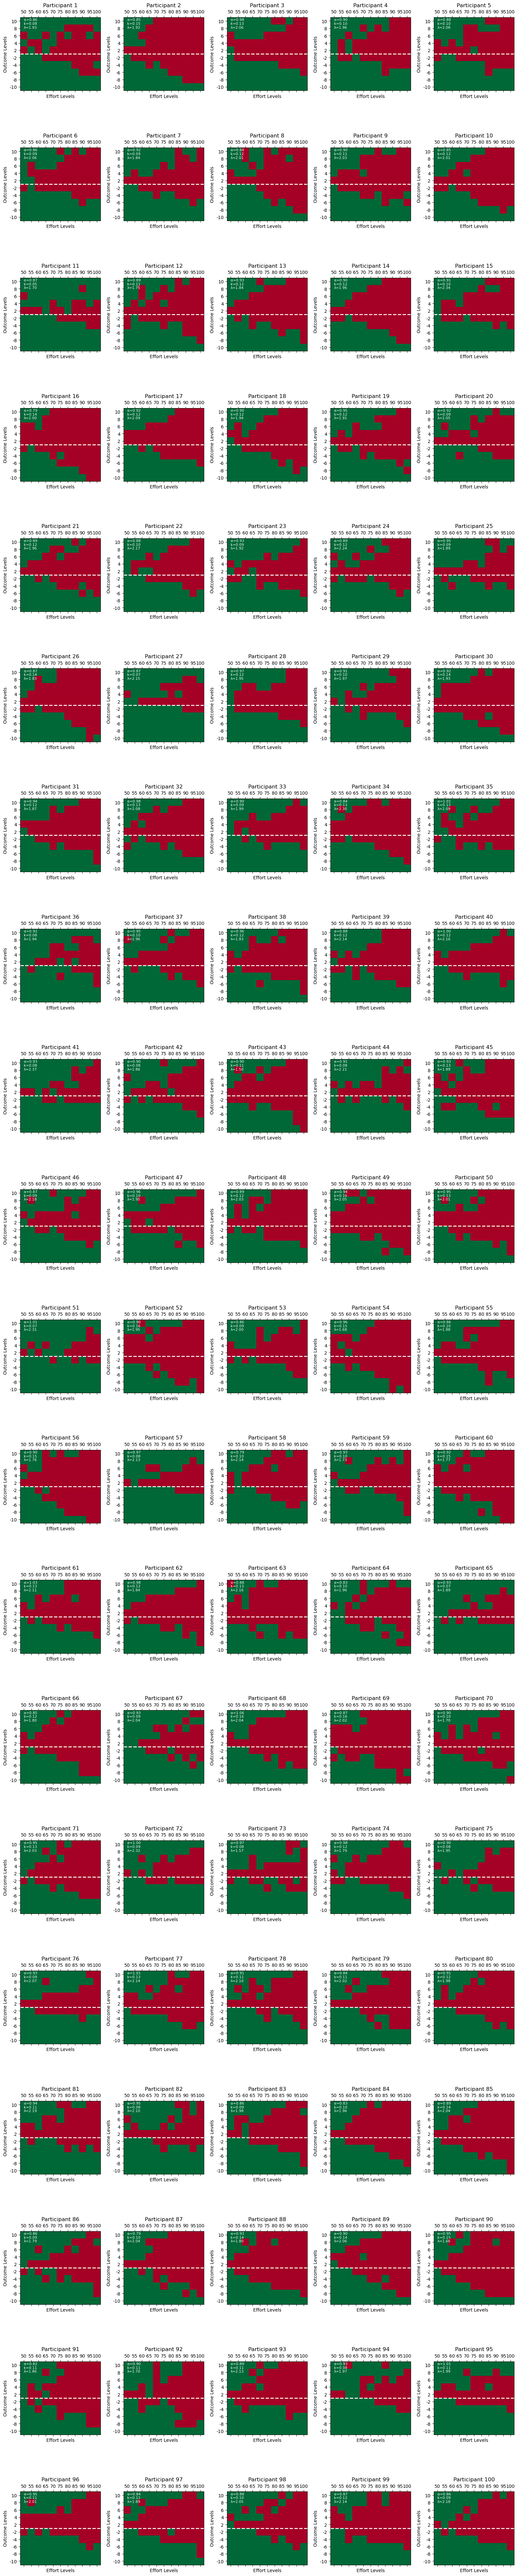

In [598]:
# Visualizing the acceptance rates for each participant separately
num_cols = 5 
num_rows = num_participants // num_cols + (1 if num_participants % num_cols else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

for participant_idx in range(num_participants):
    row = participant_idx // num_cols
    col = participant_idx % num_cols
    
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    participant_responses = responses[:, participant_idx]
    participant_acceptance_matrix = participant_responses.reshape(len(outcome_levels), len(effort_levels))
    
    cax = ax.matshow(participant_acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
    
    ax.set_xticks(np.arange(len(effort_levels)))
    ax.set_yticks(np.arange(len(outcome_levels)))
    ax.set_xticklabels((effort_levels*10).astype(int))
    ax.set_yticklabels(outcome_levels.astype(int))
    ax.invert_yaxis()
    lowest_reward_index = np.where(outcome_levels == 2)[0][0]
    ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Effort Levels')
    ax.set_ylabel('Outcome Levels')
    ax.set_title(f'Participant {participant_idx + 1}')

    # Print participant parameters 
    params_text = (f"α={alpha_values[participant_idx]:.2f} \n"
                   f"k={k_values[participant_idx]:.2f} \n"
                   f"λ={lambda_values[participant_idx]:.2f}")
    ax.text(0, len(outcome_levels) - 2, params_text, color='white', fontsize=8)

plt.tight_layout()
plt.show()

### Generate trial schedules

Schedule 1


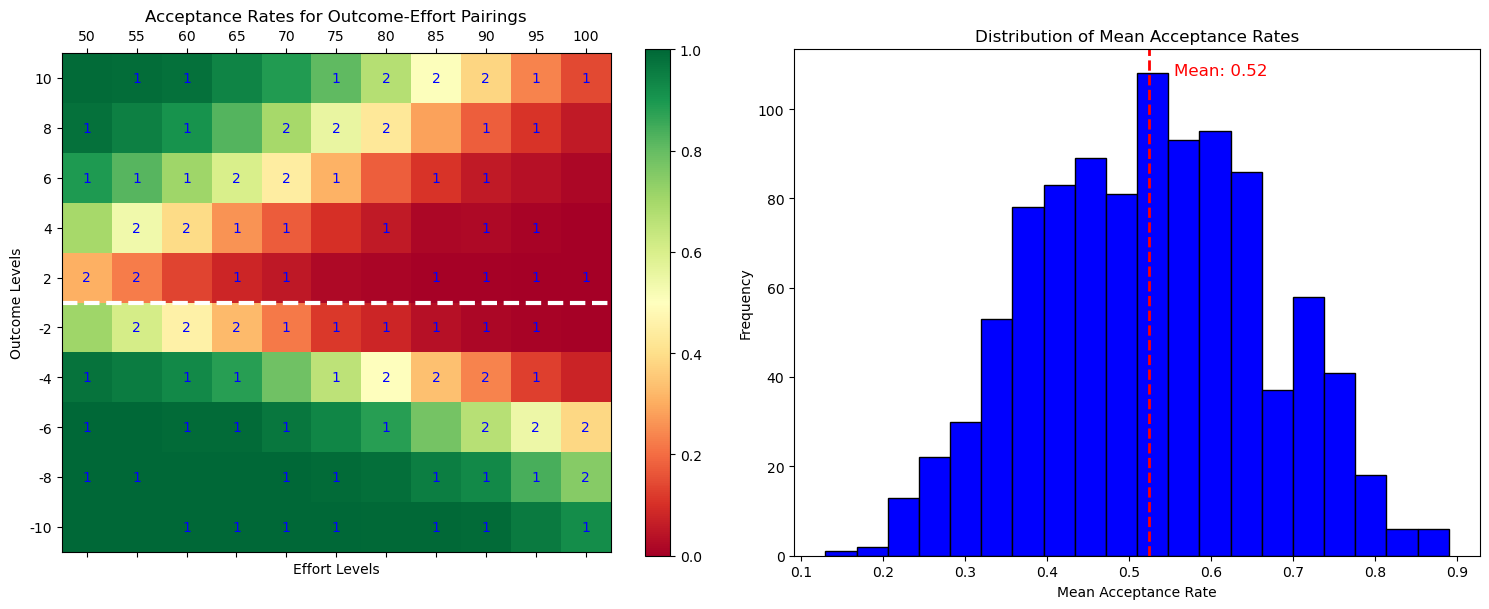

Schedule 2


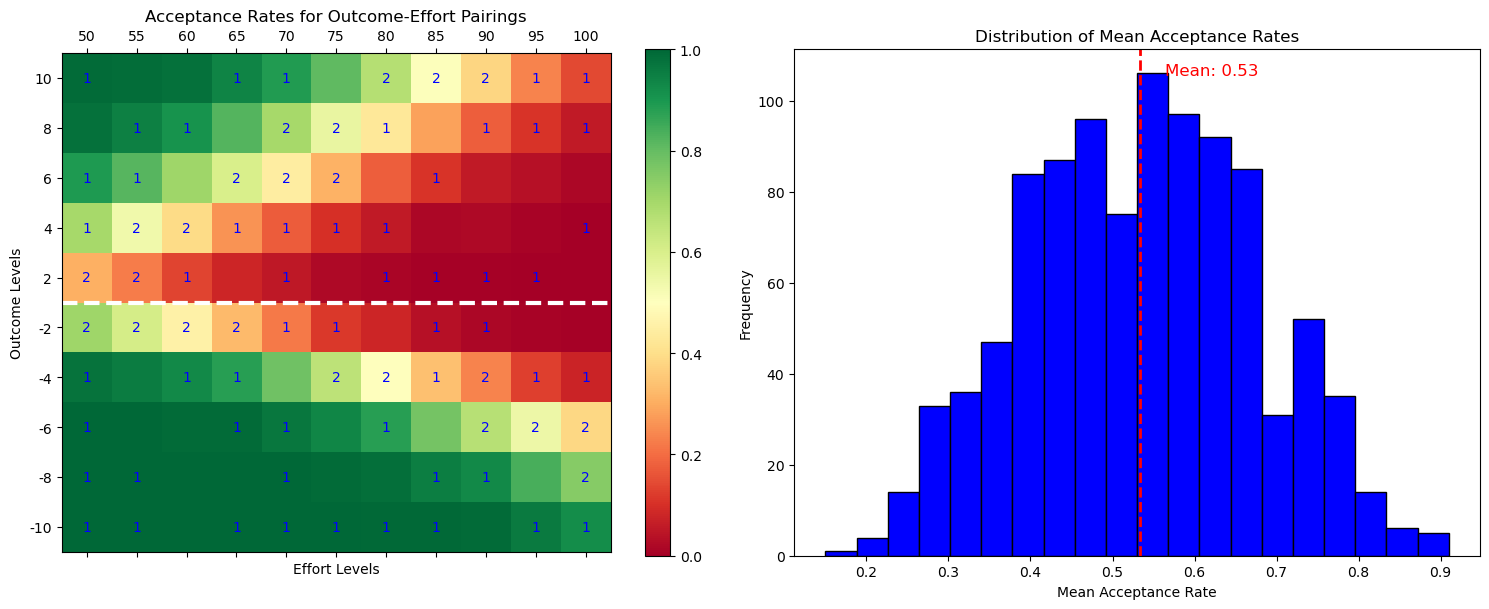

Schedule 3


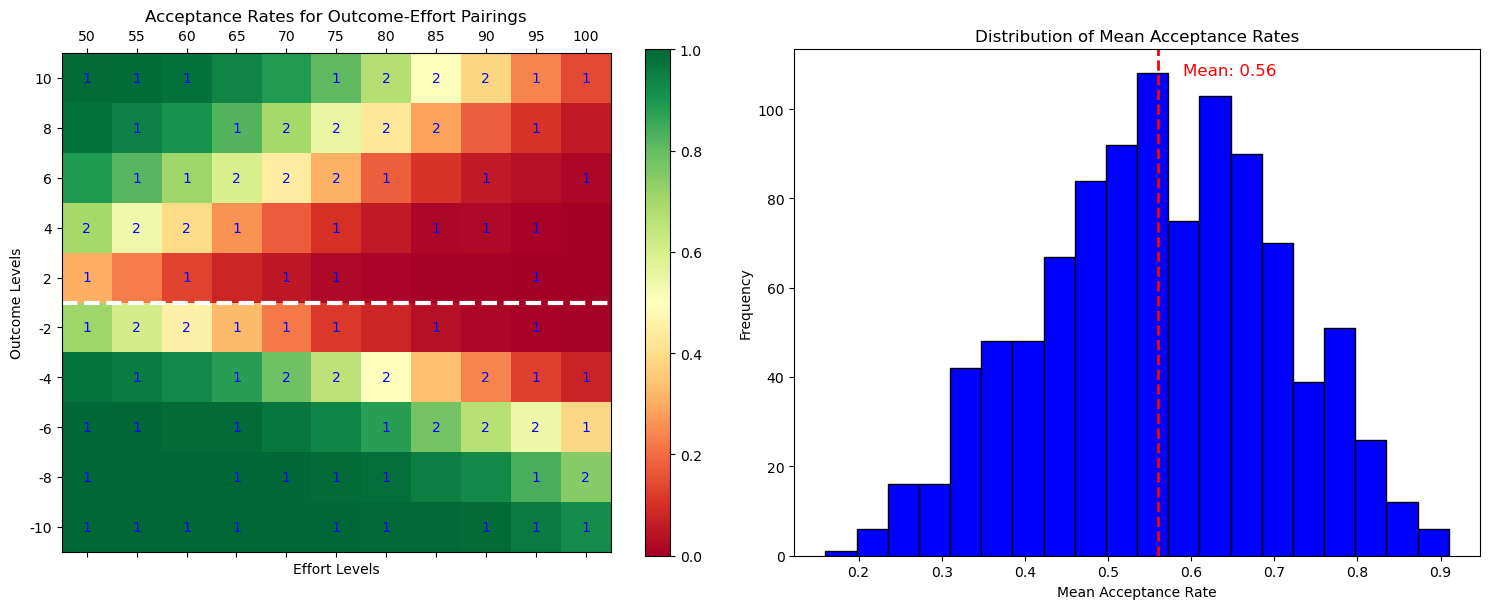

Schedule 4


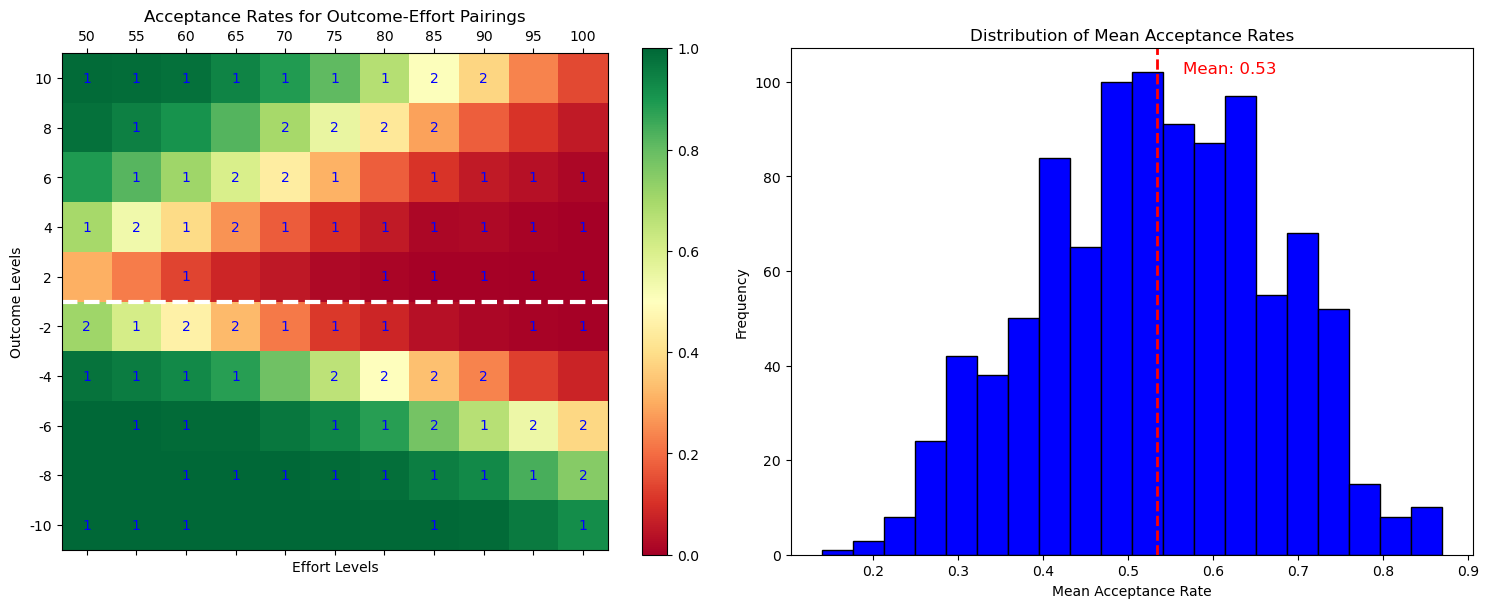

Schedule 5


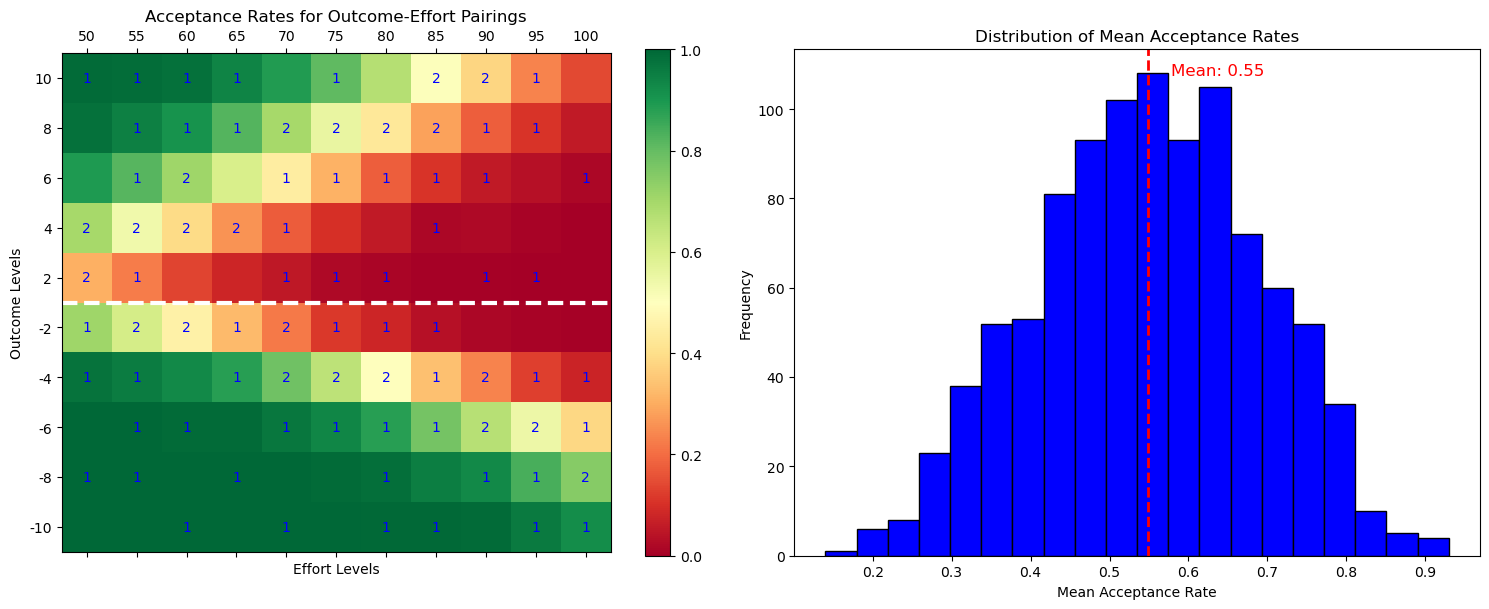

In [599]:
# Define the number of trials and structure for the experiment
num_trials = 400  # Total number of trials
num_blocks = 8  # Number of blocks, each block represents a unique condition combination
num_trials_per_block = int(num_trials / num_blocks)  # Trials per block

# Define reward and effort levels
outcome_levels_n = np.linspace(-10, 10, 11)  # Reward levels ranging from -10 to 10
outcome_levels = outcome_levels_n[outcome_levels_n != 0]  # Remove 0 from reward levels
effort_levels = np.linspace(5, 10, 11)  # Effort levels ranging from 5 to 10

# Simulate participants with different sensitivities based on literature values
num_participants = 1000  # Number of participants to simulate
# Mean and standard deviation of sensitivity parameters for the original participants
alpha_mean, alpha_std = 0.9, 0.05  # Reward sensitivity parameters
lambda_mean, lambda_std = 2.0, 0.2  # Loss aversion parameters
k_mean, k_std = 0.11, 0.02  # Effort sensitivity parameters

# Generate sensitivity parameters for each participant from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)

# Ensure parameters are within reasonable bounds
alpha_values = np.clip(alpha_values, 0.7, 1.2)
lambda_values = np.clip(lambda_values, 1.5, 2.5)
k_values = np.clip(k_values, 0, 1)

# Function to calculate net value based on outcome, effort, and sensitivity parameters
def calculate_net_value(outcome, effort, alpha, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # For positive outcomes
    else:
        return abs(-lambda_ * ((-outcome) ** alpha)) - k * (effort ** 2)  # For negative outcomes

# Logistic function to convert net value to choice probabilities
decision_beta = 1  
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))

# Generate stimuli and simulate responses
stimuli = []  # List to store stimuli
responses = []  # List to store responses

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                               for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
        # Calculate acceptance probabilities using logistic function
        probabilities = logistic_choice_prob(net_values, decision_beta)
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array and calculate acceptance rates
responses = np.array(responses)
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates to create a matrix for outcome-effort pairings
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

# Calculate sampling density inversely proportional to distance from 0.5 acceptance rate
distance_from_05 = np.abs(acceptance_rates - 0.5)
distance_from_05[distance_from_05 == 0] = 1e-6  # Avoid division by zero
sampling_density = 1 / (distance_from_05) 

# Create index pairs for positive and negative outcomes combined with all effort levels
positive_outcomes_idx = np.where(outcome_levels > 0)[0]
negative_outcomes_idx = np.where(outcome_levels < 0)[0]
positive_pairs = [(i, j) for i in positive_outcomes_idx for j in range(len(effort_levels))]
negative_pairs = [(i, j) for i in negative_outcomes_idx for j in range(len(effort_levels))]

# Calculate sampling probabilities for positive and negative pairs based on sampling densities
positive_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in positive_pairs])
negative_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in negative_pairs])

# Normalize sampling densities to get probabilities
positive_sampling_prob = positive_sampling_density / positive_sampling_density.sum()
negative_sampling_prob = negative_sampling_density / negative_sampling_density.sum()

# Function to generate a schedule of trials
def generate_schedule(seed):
    np.random.seed(seed)
    # Initialize lists and counters for selected pairs
    selected_positive_pairs = []
    selected_negative_pairs = []
    positive_pair_counts = {pair: 0 for pair in positive_pairs}
    negative_pair_counts = {pair: 0 for pair in negative_pairs}
    
    # Sample positive pairs
    while len(selected_positive_pairs) < num_trials_per_block:
        sampled_index = np.random.choice(len(positive_pairs), p=positive_sampling_prob)
        sampled_pair = positive_pairs[sampled_index]
        pair_acceptance_rate = acceptance_rates[sampled_pair[0] * len(effort_levels) + sampled_pair[1]]
        if positive_pair_counts[sampled_pair] < 1 or (positive_pair_counts[sampled_pair] < 2 and 0.2 <= pair_acceptance_rate <= 0.8):
            selected_positive_pairs.append(sampled_pair)
            positive_pair_counts[sampled_pair] += 1

    # Sample negative pairs
    while len(selected_negative_pairs) < num_trials_per_block:
        sampled_index = np.random.choice(len(negative_pairs), p=negative_sampling_prob)
        sampled_pair = negative_pairs[sampled_index]
        pair_acceptance_rate = acceptance_rates[sampled_pair[0] * len(effort_levels) + sampled_pair[1]]
        if negative_pair_counts[sampled_pair] < 1 or (negative_pair_counts[sampled_pair] < 2 and 0.2 <= pair_acceptance_rate <= 0.8):
            selected_negative_pairs.append(sampled_pair)
            negative_pair_counts[sampled_pair] += 1

    schedule = selected_positive_pairs + selected_negative_pairs

    # Visualize the schedule
    pair_counts = {}
    acceptance_rates_for_histogram = []
    for pair in schedule:
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1
        acceptance_rates_for_histogram.append(acceptance_rates[pair[0] * len(effort_levels) + pair[1]])

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot acceptance rate matrix
    cax = ax[0].matshow(acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
    fig.colorbar(cax, ax=ax[0])
    ax[0].set_xticks(np.arange(len(effort_levels)))
    ax[0].set_yticks(np.arange(len(outcome_levels)))
    ax[0].set_xticklabels((effort_levels*10).astype(int))
    ax[0].set_yticklabels(outcome_levels.astype(int))
    ax[0].invert_yaxis()
    lowest_reward_index = np.where(outcome_levels == min(abs(outcome_levels)))[0][0]
    ax[0].axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)
    ax[0].set_xlabel('Effort Levels')
    ax[0].set_ylabel('Outcome Levels')
    ax[0].set_title('Acceptance Rates for Outcome-Effort Pairings')

    # Annotate selected pairs
    for (i, j), count in pair_counts.items():
        ax[0].text(j, i, str(count), va='center', ha='center', color='blue')

    # Calculate mean acceptance rates for each participant
    participant_mean_acceptance_rates = []
    for participant_idx in range(num_participants):
        participant_responses = []
        for (outcome_idx, effort_idx) in schedule:
            pair_idx = outcome_idx * len(effort_levels) + effort_idx
            participant_responses.append(responses[pair_idx, participant_idx])
        mean_acceptance_rate = np.mean(participant_responses)
        participant_mean_acceptance_rates.append(mean_acceptance_rate)
    
    # Plot histogram of mean acceptance rates
    ax[1].hist(participant_mean_acceptance_rates, bins=20, color='blue', edgecolor='black')
    overall_mean_acceptance_rate = np.mean(participant_mean_acceptance_rates)
    ax[1].axvline(overall_mean_acceptance_rate, color='red', linestyle='--', linewidth=2)
    label_x_position = overall_mean_acceptance_rate + 0.03  
    label_y_position = ax[1].get_ylim()[1] * 0.95
    ax[1].text(label_x_position, label_y_position, f'Mean: {overall_mean_acceptance_rate:.2f}', color='red', fontsize=12)
    ax[1].set_xlabel('Mean Acceptance Rate')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title('Distribution of Mean Acceptance Rates')

    plt.tight_layout()
    plt.show()

    return schedule

# Generate multiple schedules
num_schedules = 5
schedules = []

# Generate schedules by calling generate_schedule with different seeds
for seed in range(num_schedules):
    print(f"Schedule {seed + 1}")
    schedule = generate_schedule(seed)
    schedules.append(schedule)

### Test robustness of trial schedules

In [600]:
# Function to calculate acceptance rates for new participants based on the generated schedule
def calculate_new_participants_acceptance_rates(schedule, alpha_values, lambda_values, k_values):
    participant_mean_acceptance_rates = []
    for participant_idx in range(num_participants):
        participant_responses = []
        for (outcome_idx, effort_idx) in schedule:
            pair_idx = outcome_idx * len(effort_levels) + effort_idx
            outcome, effort = stimuli[pair_idx]
            net_value = calculate_net_value(outcome, effort, alpha_values[participant_idx], k_values[participant_idx], lambda_values[participant_idx])
            acceptance_probability = logistic_choice_prob(net_value, decision_beta)
            participant_responses.append(acceptance_probability)
        mean_acceptance_rate = np.mean(participant_responses)
        participant_mean_acceptance_rates.append(mean_acceptance_rate)
    return participant_mean_acceptance_rates

##### Shifting by absolute numbers

In [601]:
# Function to perform sensitivity analysis
def sensitivity_analysis(param_name, param_mean, param_std, param_absolute_shifts):
    results = []
    for i, schedule in enumerate(schedules):
        upper_threshold = None
        lower_threshold = None
        for shift in param_absolute_shifts:
            shift_positive = shift
            shift_negative = -shift

            alpha_values_shifted_pos = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            alpha_values_shifted_neg = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            lambda_values_shifted_pos = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            lambda_values_shifted_neg = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            k_values_shifted_pos = k_values if param_name != 'k' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            k_values_shifted_neg = k_values if param_name != 'k' else np.random.normal(param_mean + shift_negative, param_std, num_participants)

            participant_mean_acceptance_rates_pos = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_pos, lambda_values_shifted_pos, k_values_shifted_pos)
            mean_acceptance_rate_pos = np.mean(participant_mean_acceptance_rates_pos)
            
            participant_mean_acceptance_rates_neg = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_neg, lambda_values_shifted_neg, k_values_shifted_neg)
            mean_acceptance_rate_neg = np.mean(participant_mean_acceptance_rates_neg)

            if upper_threshold is None and mean_acceptance_rate_pos > 0.6:
                upper_threshold = shift
            if lower_threshold is None and mean_acceptance_rate_neg < 0.4:
                lower_threshold = shift
            
            if upper_threshold is not None and lower_threshold is not None:
                break
        
        results.append((i + 1, upper_threshold, lower_threshold))

    # Printing results in specified format
    for schedule_num, upper, lower in results:
        print(f"Schedule {schedule_num}\nupper threshold: + {upper:.2f}\nlower threshold: - {lower:.2f}\n")

# Define ranges for parameter shifts as absolute values
param_absolute_shifts = np.arange(0, 10, 0.1)  # steps of 0.1

# Perform sensitivity analysis for alpha
print("Sensitivity analysis for alpha:")
sensitivity_analysis('alpha', alpha_mean, alpha_std, param_absolute_shifts)

# Perform sensitivity analysis for lambda
print("\nSensitivity analysis for lambda:")
sensitivity_analysis('lambda', lambda_mean, lambda_std, param_absolute_shifts)

# Perform sensitivity analysis for k
print("\nSensitivity analysis for k:")
sensitivity_analysis('k', k_mean, k_std, param_absolute_shifts)


Sensitivity analysis for alpha:
Schedule 1
upper threshold: + 0.10
lower threshold: - 0.20

Schedule 2
upper threshold: + 0.10
lower threshold: - 0.20

Schedule 3
upper threshold: + 0.10
lower threshold: - 0.20

Schedule 4
upper threshold: + 0.10
lower threshold: - 0.20

Schedule 5
upper threshold: + 0.10
lower threshold: - 0.20


Sensitivity analysis for lambda:
Schedule 1
upper threshold: + 0.70
lower threshold: - 0.80

Schedule 2
upper threshold: + 0.60
lower threshold: - 0.80

Schedule 3
upper threshold: + 0.30
lower threshold: - 0.90

Schedule 4
upper threshold: + 0.50
lower threshold: - 0.70

Schedule 5
upper threshold: + 0.40
lower threshold: - 0.80


Sensitivity analysis for k:


/var/folders/d0/p878jscj4m1f6w4d3xn26m1w0000gn/T/ipykernel_2509/4250888667.py:38: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-decision_beta * net_value))


KeyboardInterrupt: 

##### Shifting parameters by % of mean

In [602]:
# Function to perform sensitivity analysis
def sensitivity_analysis(param_name, param_mean, param_std, param_percentage_range):
    results = []
    for i, schedule in enumerate(schedules):
        upper_threshold = None
        lower_threshold = None
        for percentage in param_percentage_range:
            shift_positive = param_mean * (percentage / 100)
            shift_negative = -param_mean * (percentage / 100)

            alpha_values_shifted_pos = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            alpha_values_shifted_neg = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            lambda_values_shifted_pos = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            lambda_values_shifted_neg = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            k_values_shifted_pos = k_values if param_name != 'k' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            k_values_shifted_neg = k_values if param_name != 'k' else np.random.normal(param_mean + shift_negative, param_std, num_participants)

            participant_mean_acceptance_rates_pos = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_pos, lambda_values_shifted_pos, k_values_shifted_pos)
            mean_acceptance_rate_pos = np.mean(participant_mean_acceptance_rates_pos)
            
            participant_mean_acceptance_rates_neg = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_neg, lambda_values_shifted_neg, k_values_shifted_neg)
            mean_acceptance_rate_neg = np.mean(participant_mean_acceptance_rates_neg)

            if upper_threshold is None and mean_acceptance_rate_pos > 0.6:
                upper_threshold = percentage
            if lower_threshold is None and mean_acceptance_rate_neg < 0.4:
                lower_threshold = percentage
            
            if upper_threshold is not None and lower_threshold is not None:
                break
        
        results.append((i + 1, upper_threshold, lower_threshold))

    # Printing results in specified format
    for schedule_num, upper, lower in results:
        print(f"Schedule {schedule_num}\nupper threshold: + {upper}%\nlower threshold: - {lower}%\n")

# Define ranges for parameter shifts as percentages
param_percentage_range = np.arange(0, 100, 1)  # steps of 1%

# Perform sensitivity analysis for alpha
print("Sensitivity analysis for alpha:")
sensitivity_analysis('alpha', alpha_mean, alpha_std, param_percentage_range)

# Perform sensitivity analysis for lambda
print("\nSensitivity analysis for lambda:")
sensitivity_analysis('lambda', lambda_mean, lambda_std, param_percentage_range)

# Perform sensitivity analysis for k
print("\nSensitivity analysis for k:")
sensitivity_analysis('k', k_mean, k_std, param_percentage_range)


Sensitivity analysis for alpha:
Schedule 1
upper threshold: + 9%
lower threshold: - 13%

Schedule 2
upper threshold: + 8%
lower threshold: - 15%

Schedule 3
upper threshold: + 5%
lower threshold: - 16%

Schedule 4
upper threshold: + 8%
lower threshold: - 14%

Schedule 5
upper threshold: + 6%
lower threshold: - 16%


Sensitivity analysis for lambda:
Schedule 1
upper threshold: + 31%
lower threshold: - 36%

Schedule 2
upper threshold: + 27%
lower threshold: - 39%

Schedule 3
upper threshold: + 15%
lower threshold: - 44%

Schedule 4
upper threshold: + 25%
lower threshold: - 36%

Schedule 5
upper threshold: + 19%
lower threshold: - 39%


Sensitivity analysis for k:
Schedule 1
upper threshold: + None%
lower threshold: - None%

Schedule 2
upper threshold: + None%
lower threshold: - None%

Schedule 3
upper threshold: + None%
lower threshold: - None%

Schedule 4
upper threshold: + None%
lower threshold: - None%

Schedule 5
upper threshold: + None%
lower threshold: - None%



##### Shifting parameters by std

In [603]:
# Function to perform sensitivity analysis
def sensitivity_analysis(param_name, param_mean, param_std, param_std_range):
    results = []
    for i, schedule in enumerate(schedules):
        upper_threshold = None
        lower_threshold = None
        for num_std in param_std_range:
            shift_positive = param_std * num_std
            shift_negative = -param_std * num_std

            alpha_values_shifted_pos = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            alpha_values_shifted_neg = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            lambda_values_shifted_pos = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            lambda_values_shifted_neg = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            k_values_shifted_pos = k_values if param_name != 'k' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            k_values_shifted_neg = k_values if param_name != 'k' else np.random.normal(param_mean + shift_negative, param_std, num_participants)

            participant_mean_acceptance_rates_pos = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_pos, lambda_values_shifted_pos, k_values_shifted_pos)
            mean_acceptance_rate_pos = np.mean(participant_mean_acceptance_rates_pos)
            
            participant_mean_acceptance_rates_neg = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_neg, lambda_values_shifted_neg, k_values_shifted_neg)
            mean_acceptance_rate_neg = np.mean(participant_mean_acceptance_rates_neg)

            if upper_threshold is None and mean_acceptance_rate_pos > 0.6:
                upper_threshold = num_std
            if lower_threshold is None and mean_acceptance_rate_neg < 0.4:
                lower_threshold = num_std
            
            if upper_threshold is not None and lower_threshold is not None:
                break
        
        results.append((i + 1, upper_threshold, lower_threshold))

    # Printing results in specified format
    for schedule_num, upper, lower in results:
        print(f"Schedule {schedule_num}\nupper threshold: + {upper:.2f} std\nlower threshold: - {lower:.2f} std\n")

# Define ranges for parameter shifts in terms of standard deviations
param_std_range = np.arange(0, 20, 0.1)  # steps of 0.1 standard deviations

# Perform sensitivity analysis for alpha
print("Sensitivity analysis for alpha:")
sensitivity_analysis('alpha', alpha_mean, alpha_std, param_std_range)

# Perform sensitivity analysis for lambda
print("\nSensitivity analysis for lambda:")
sensitivity_analysis('lambda', lambda_mean, lambda_std, param_std_range)

# Perform sensitivity analysis for k
print("\nSensitivity analysis for k:")
sensitivity_analysis('k', k_mean, k_std, param_std_range)


Sensitivity analysis for alpha:
Schedule 1
upper threshold: + 1.60 std
lower threshold: - 2.40 std

Schedule 2
upper threshold: + 1.40 std
lower threshold: - 2.70 std

Schedule 3
upper threshold: + 0.80 std
lower threshold: - 2.90 std

Schedule 4
upper threshold: + 1.40 std
lower threshold: - 2.60 std

Schedule 5
upper threshold: + 1.10 std
lower threshold: - 2.70 std


Sensitivity analysis for lambda:
